In [33]:
import pandas as pd
import yfinance as yf
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.dates as mdates
from portfolio_utils import *
# import ace_tools as tools; 

# 配置中文字体
plt.rcParams['font.family'] = 'Heiti TC'

# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({'font.size': 12})

In [34]:
#### 按照排序分配权重的策略
# 初始分配权重
def initial_weights(stock_symbols):
    num_stocks = len(stock_symbols)
    return np.ones(num_stocks) / num_stocks

# 重新分配权重
def rebalance_weights(z_scores, date, initial_weight):
    ranked_stocks = z_scores.loc[date].sort_values()
    num_stocks = len(ranked_stocks)
    new_weights = np.zeros(num_stocks)
    
    # 根据排序结果重新分配权重
    for i, stock in enumerate(ranked_stocks.index):
        new_weights[i] = initial_weight * (1 + ranked_stocks.index.get_loc(stock) / num_stocks)
    new_weights /= new_weights.sum()  # 归一化权重

    return new_weights

def rebalance_rank_portfolio(stock_prices, window, initial_capital):
    transaction_cost=0.005
    lot_size=100
    min_trade_volume = 200
    z_scores = calculate_z_score(stock_prices, window)
    
    num_stocks = len(stock_prices.columns)
    initial_weight = 1 / num_stocks
    weights = initial_weights(stock_prices.columns)
    portfolio_value = initial_capital
    portfolio_values = [initial_capital]
    positions = np.zeros((len(stock_prices.index[window-1:]), num_stocks))  # 存储每个交易日的仓位
    adjustments = np.zeros_like(positions)  # 存储每个交易日的调整信号
    current_positions = np.zeros(num_stocks)
    positions[0] = current_positions
    cash = initial_capital
    buy_count = []
    sell_count = []
    annual_buy_count = 0
    annual_sell_count = 0
    current_year = stock_prices.index[window].year

    for t, date in enumerate(stock_prices.index[window:], start=1):
        if date.year != current_year:
            buy_count.append(annual_buy_count)
            sell_count.append(annual_sell_count)
            annual_buy_count = 0
            annual_sell_count = 0
            current_year = date.year
        
        # 根据Z-score排序重新分配权重
        new_weights = rebalance_weights(z_scores, date, initial_weight)
        
        # 根据新的权重进行买卖股票
        for i, stock in enumerate(stock_prices.columns):
            current_price = stock_prices[stock].loc[date]
            desired_position = portfolio_value * new_weights[i] // current_price
            
            # 检查交易量是否达到最低交易量限制
            trade_volume = abs(desired_position - current_positions[i]) * current_price
            if trade_volume < min_trade_volume:
                continue  # 如果交易量小于最低限制，则跳过此交易
            
            if desired_position > current_positions[i]:
                buy_amount = (desired_position - current_positions[i]) // lot_size * lot_size
                if buy_amount > 0 and cash >= buy_amount * current_price * (1 + transaction_cost):
                    current_positions[i] += buy_amount
                    cash -= buy_amount * current_price * (1 + transaction_cost)
                    annual_buy_count += 1
            elif desired_position < current_positions[i]:
                sell_amount = (current_positions[i] - desired_position) // lot_size * lot_size
                if sell_amount > 0:
                    current_positions[i] -= sell_amount
                    cash += sell_amount * current_price * (1 - transaction_cost)
                    annual_sell_count += 1

        weights = new_weights
        portfolio_value = cash + np.sum(current_positions * stock_prices.loc[date])
        portfolio_values.append(portfolio_value)
        positions[t] = current_positions  # 记录仓位
        
    buy_count.append(annual_buy_count)
    sell_count.append(annual_sell_count)

    return portfolio_values, weights, positions, adjustments, buy_count, sell_count

In [35]:
### 按照Portfolio Optimization分配权重
def rebalance_portfolio(stock_prices, SSINDX, window, initial_capital, short_ma=None, long_ma=None):
    lot_size=100
    transaction_cost = 0.005
    min_trade_volume = 100
    
    num_stocks = len(stock_prices.columns)
    z_scores = calculate_z_score(stock_prices, window)
    cov_matrix = stock_prices.pct_change().cov()
    mean_returns = stock_prices.pct_change().mean()
    dynamic_thresholds = dynamic_threshold(SSINDX, window)

    weights = portfolio_optimization(mean_returns, cov_matrix)
    portfolio_value = initial_capital
    portfolio_values = [initial_capital]
    positions = np.zeros((len(stock_prices.index[window-1:]), num_stocks))  # 存储每个交易日的仓位
    adjustments = np.zeros_like(positions)  # 存储每个交易日的调整信号
    current_positions = np.zeros(num_stocks)
    cash = initial_capital
    buy_count = []
    sell_count = []
    annual_buy_count = 0
    annual_sell_count = 0
    current_year = stock_prices.index[window].year
    
    positions[0] = current_positions

    for t, date in enumerate(stock_prices.index[window:], start=1):
        # 获取当前交易日的动态阈值
        threshold = dynamic_thresholds.loc[date]
        if date.year != current_year:
            buy_count.append(annual_buy_count)
            sell_count.append(annual_sell_count)
            annual_buy_count = 0
            annual_sell_count = 0
            current_year = date.year
        
        # 根据Z-score和趋势调整权重
        new_weights = np.zeros(len(weights))
        for i, stock in enumerate(stock_prices.columns):
            if short_ma[stock].loc[date] > long_ma[stock].loc[date]:  # 确保在多头市场
                if z_scores[stock].loc[date] < -threshold:
                    new_weights[i] = weights[i] + 0.01
                elif z_scores[stock].loc[date] > threshold:
                    new_weights[i] = weights[i] - 0.01
                else:
                    new_weights[i] = weights[i]
            else:
                new_weights[i] = weights[i]  # 保持不变
                
        
        new_weights = np.clip(new_weights, 0, 1)
        new_weights = new_weights / np.sum(new_weights)
        
        # 根据新的权重进行买卖股票
        for i, stock in enumerate(stock_prices.columns):
            current_price = stock_prices[stock].loc[date]
            desired_position = portfolio_value * new_weights[i] // current_price
            
            # 检查交易量是否达到最低交易量限制
            trade_volume = abs(desired_position - current_positions[i]) * current_price
            if trade_volume < min_trade_volume:
                continue  # 如果交易量小于最低限制，则跳过此交易
            
            if desired_position > current_positions[i]:
                buy_amount = (desired_position - current_positions[i]) // lot_size * lot_size
                if buy_amount > 0 and cash >= buy_amount * current_price * (1 + transaction_cost):
                    current_positions[i] += buy_amount
                    cash -= buy_amount * current_price * (1 + transaction_cost)
                    annual_buy_count += 1
                    adjustments[t, i] = 1 # 买入信号
            elif desired_position < current_positions[i]:
                sell_amount = (current_positions[i] - desired_position) // lot_size * lot_size
                if sell_amount > 0:
                    current_positions[i] -= sell_amount
                    cash += sell_amount * current_price * (1 - transaction_cost)
                    annual_sell_count += 1
                    adjustments[t, i] = -1  # 卖出信号
            else: adjustments[t, i] = 0  # 卖出信号
    
        weights = new_weights
        portfolio_value = cash + np.sum(current_positions * stock_prices.loc[date])
        portfolio_values.append(portfolio_value)
        positions[t] = current_positions  # 记录仓位
    
    buy_count.append(annual_buy_count)
    sell_count.append(annual_sell_count)

    return portfolio_values, weights, positions, adjustments, buy_count, sell_count


In [36]:
# 读取Excel文件
df = pd.read_excel('Stocks.xlsx', sheet_name='Holdlist')

# 获取股票代码列表
stock_symbols = df['Stock Symbol'].tolist()
stock_names = df['Stock Name'].tolist()

# 定义时间范围
start_date = '2022-01-01'
# start_date = '2024-06-01'
end_date = '2024-08-31'

# 设置参数
#initial_capital = 34000
initial_capital = 37000
window = 10
threshold = 2.5
transaction_cost = 0.005  # 假设交易成本为0.5%
rebalance_period = 7  # 调仓周期为3天

stock_data = get_stock_price(stock_symbols, start_date, end_date)
# stock_data = get_stock_price()
# 获取上证指数数据
SSINDX = yf.download('000001.SS', start_date, end_date)['Close']

# Ensure stock_data is a DataFrame and handle any missing values
stock_prices = pd.DataFrame(stock_data).ffill().bfill()
dates = stock_prices.index[window-1:]
short_window = 40
long_window = 200
short_ma, long_ma = calculate_moving_average(stock_prices, short_window, long_window)

# 调整rebalance_portfolio函数的调用
portfolio_values, weights, positions, adjustments, buy_count, sell_count = rebalance_portfolio(stock_prices, SSINDX, window, initial_capital, short_ma, long_ma)
portfolio_values1, weights1, positions1, adjustments1, buy_count1, sell_count1 = rebalance_rank_portfolio(stock_prices=stock_prices, window=window, initial_capital=initial_capital)
benchmark = SSINDX / SSINDX.iloc[0] * portfolio_values[0]
print(f'Final Portfolio Value: {portfolio_values[-1]}')
print(f'Final Portfolio Value: {portfolio_values1[-1]}')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Final Portfolio Value: 51714.32567119599
Final Portfolio Value: 51037.857500225306


In [37]:
# Total PnL Summary
summary_total = pnl_summary_total(portfolio_values, dates, positions, stock_prices, window=window)
summary_total

,Total Return %,Annualized Return %,Sharpe Ratio,Max Drawdown %,Turnover %,Fitness
0,39.77,13.64,0.96,12.61,1.37,1.01


In [38]:
summary_total1 = pnl_summary_total(portfolio_values1, dates, positions1, stock_prices,window=window)
summary_total1

,Total Return %,Annualized Return %,Sharpe Ratio,Max Drawdown %,Turnover %,Fitness
0,37.94,13.07,0.92,12.09,1.35,0.94


In [39]:
# PnL Summary of Portfolio Optimization
summary = pnl_summary(portfolio_values, dates, buy_count, sell_count)
summary

,Start Value,End Value,Return Std,Annual Return %,Sharpe Ratio,Max Drawdown %,Buy Count,Sell Count
Year,,,,,,,,
2022,37000.00,35533.46,0.01,-3.96,-0.25,11.45,69,42
2023,35821.83,41507.02,0.01,15.87,1.56,7.07,51,50
2024,41909.33,51714.33,0.01,23.40,1.22,12.61,76,61


In [40]:
# PnL Summary of Rank Method
summary1 = pnl_summary(portfolio_values1, dates, buy_count1, sell_count1)
summary1

,Start Value,End Value,Return Std,Annual Return %,Sharpe Ratio,Max Drawdown %,Buy Count,Sell Count
Year,,,,,,,,
2022,37000.00,35771.09,0.01,-3.32,-0.21,12.09,31,7
2023,36070.23,40339.36,0.01,11.84,1.12,8.01,11,16
2024,40765.80,51037.86,0.01,25.20,1.32,11.37,34,29


### PnL Visualization

In [41]:
# Interactive Plot for Portfolio Value
pnl_visualization(dates=dates, portfolio_values=portfolio_values, benchmark=benchmark)

In [42]:
# Interactive Plot for Portfolio Value
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=portfolio_values1, mode='lines', name='Portfolio Value'))
fig.add_trace(go.Scatter(x=dates, y=benchmark, mode='lines',name='SSINDX PnL'))
fig.update_layout(title='Portfolio Value Over Time', xaxis_title='Date', yaxis_title='Portfolio Value', hovermode='x unified')
fig.show()

### Visualization

In [43]:
plot_historical_positions(dates, positions, stock_names, stock_prices, window=window)

In [44]:
plot_historical_positions(dates, positions1, stock_names, stock_prices, window=window)

In [45]:
plot_current_positions(weights, stock_names)

In [46]:
plot_current_positions(weights1, stock_names)

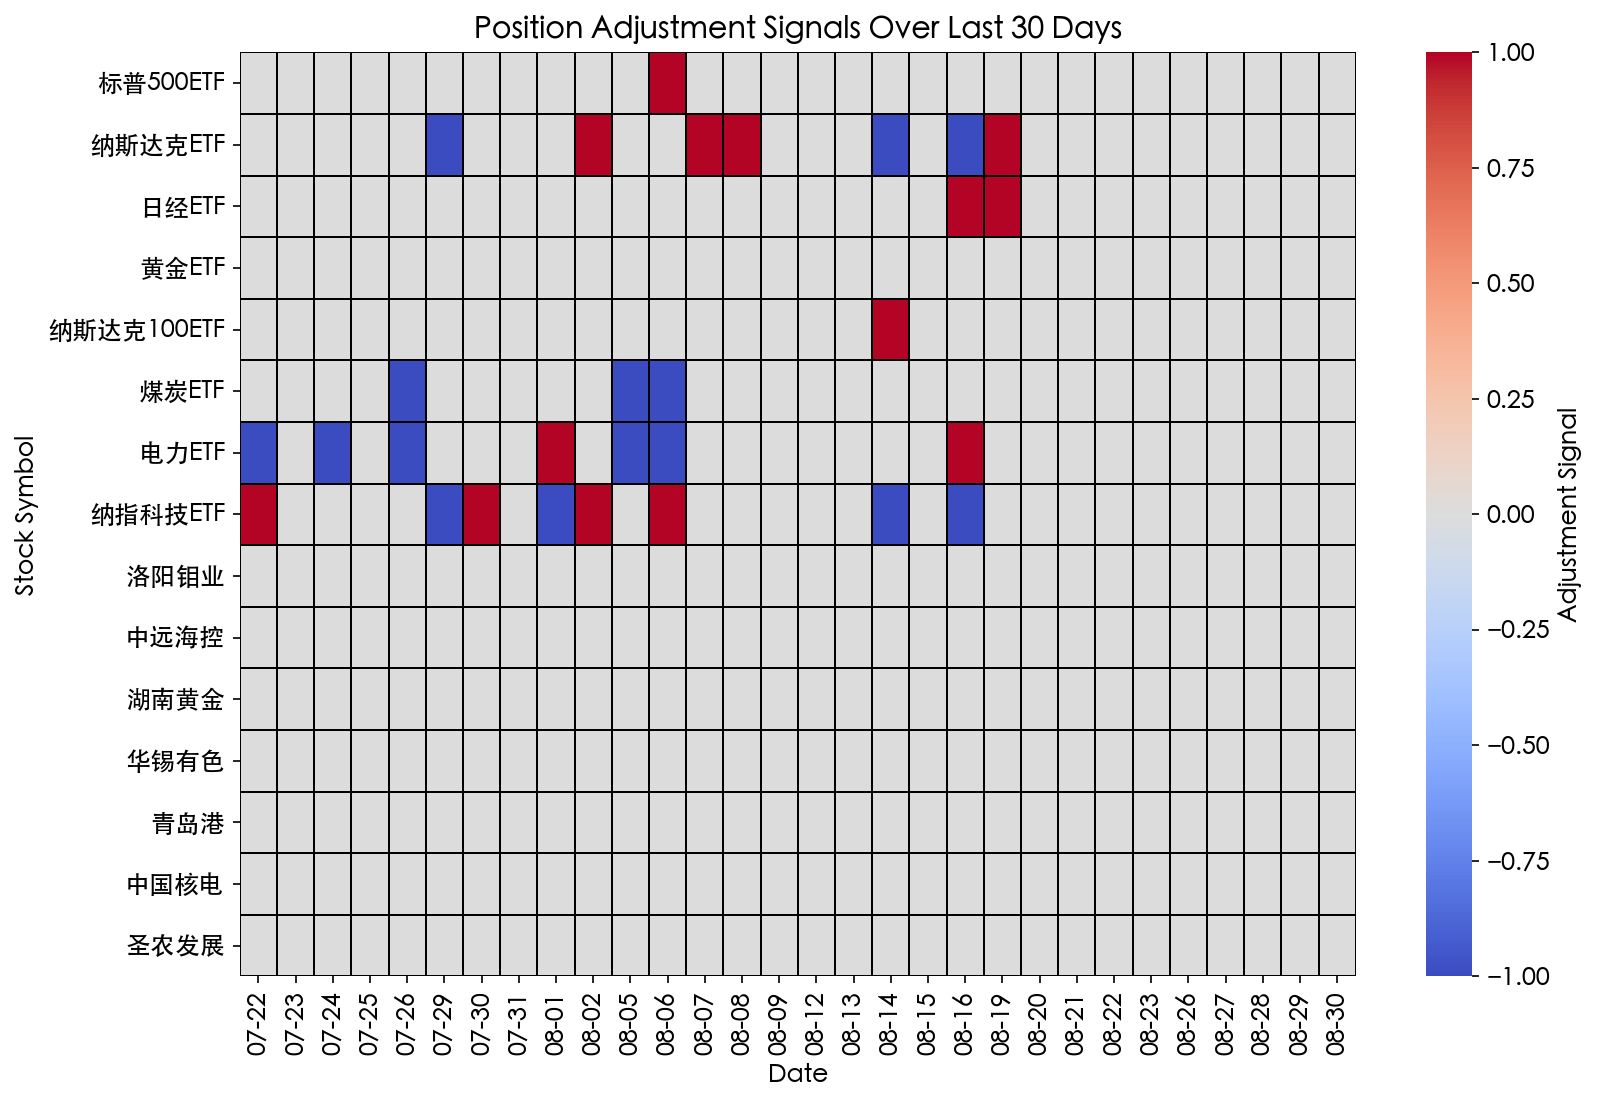

In [47]:
plot_adjustment_heatmap(dates, adjustments, stock_names)

In [48]:
position_table = display_position_table(stock_names, positions, stock_prices, adjustments, transaction_cost=transaction_cost)
print(dates[-1])
print(f'今日盈亏：{round(portfolio_values[-1] - portfolio_values[-2], 2)}, 盈亏比例：{round((portfolio_values[-1] - portfolio_values[-2])/portfolio_values[-1] * 100, 2)}%')
position_table

2024-08-30 00:00:00
今日盈亏：277.6, 盈亏比例：0.54%


,Stock Name,Holding,PnL Today,PnL Total,Y_Weight (%),T_Weight (%),Adjustment Signal,Weight Change (%)
159509.SZ,纳指科技ETF,3300,49.5,1789.64,9.77,9.81,0.0,0.04
513300.SS,纳斯达克ETF,2800,28.0,1274.03,9.74,9.74,0.0,0.00
601298.SS,青岛港,500,-95.0,1980.57,9.05,8.82,0.0,-0.23
513110.SS,纳斯达克100ETF,2600,18.2,1513.33,8.00,8.00,0.0,-0.01
002299.SZ,圣农发展,300,60.0,-3251.81,7.02,7.10,0.0,0.08
513500.SS,标普500ETF,1800,1.8,929.92,6.91,6.88,0.0,-0.03
159611.SZ,电力ETF,3600,-3.6,52.07,6.92,6.87,0.0,-0.04
515220.SS,煤炭ETF,3000,36.0,-2366.64,6.39,6.43,0.0,0.04
601985.SS,中国核电,300,-15.0,974.15,6.42,6.36,0.0,-0.06
600301.SS,华锡有色,200,68.0,781.62,6.24,6.34,0.0,0.10
